In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import *
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.filterwarnings("ignore")

In [4]:
# hdfc=pd.read_csv("NII hdfc.csv")
hdfc=pd.read_csv("nii hdfc.csv")

# HDFC

In [5]:
hdfc.head()

,QUARTERS,NII,GROSS ADVANCE,GNPA,GNPAR,CASA,PCR,WDR,WLR
0,2016-17 Q1,7781.4,470622.0,4894.47,1.04,40.0,69.6,7.69,11.54
1,2016-17 Q2,7993.6,494418.0,5043.06,1.02,40.0,70.6,7.54,11.47
2,2016-17 Q3,8309.1,495043.0,6386.05,1.29,44.0,70.0,7.38,11.30
3,2016-17 Q4,9055.1,555000.0,5827.50,1.05,48.0,68.6,7.05,11.09
4,2017-18 Q1,9370.7,580975.8,7204.10,1.24,44.0,65.0,6.88,10.76


In [6]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def find_diff_order(df, max_diff=5):
    diff_orders = {}
    
    for col in df.columns.values[1:]:
        temp_series = df[col]
        diff_count = 0
        
        while diff_count < max_diff:
            test_result = adfuller(temp_series.dropna(), autolag="AIC")
            if test_result[1] < 0.05:
                break
            temp_series = temp_series.diff()
            diff_count += 1
        
        diff_orders[col] = diff_count
    
    return diff_orders




In [7]:
diff_needed = find_diff_order(hdfc)
print(diff_needed)

{'NII': 1, 'GROSS ADVANCE': 4, 'GNPA': 1, 'GNPAR': 0, 'CASA': 0, 'PCR': 1, 'WDR': 3, 'WLR': 0}


In [ ]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.stattools import grangercausalitytests

# # Load your dataframe (ensure it's already preprocessed and stationary)
# # hdfc = pd.read_csv("your_file.csv")  # Replace with actual data loading method

# # Differencing based on provided orders
# hdfc_diff = hdfc.copy()
# hdfc_diff = hdfc_diff.drop(['QUARTERS'], axis=1)
# hdfc_diff['NII'] = hdfc['NII'].diff(1)
# hdfc_diff['GROSS ADVANCE'] = hdfc['GROSS ADVANCE'].diff(1)
# hdfc_diff['GNPA'] = hdfc['GNPA'].diff(1)
# hdfc_diff['GNPAR'] = hdfc['GNPAR'].diff(1)
# hdfc_diff['CASA'] = hdfc['CASA'].diff(1)
# hdfc_diff['PCR'] = hdfc['PCR'].diff(1)
# hdfc_diff['WDR'] = hdfc['WDR'].diff(1)
# hdfc_diff['WLR'] = hdfc['WLR'].diff(1)

# # Drop NaN values after differencing
# hdfc_diff = hdfc_diff.dropna()

# # Running Granger causality tests for each pair of variables
# min_lag_set = 4  # Adjust as needed
# results = []

# columns = hdfc_diff.columns
# for col1 in columns:
#     for col2 in columns:
#         if col1 != col2:  # Avoid self-causality tests
#             try:
#                 result = grangercausalitytests(hdfc_diff[[col1, col2]], min_lag_set, verbose=False)

#                 # Extract p-values for different tests at the highest lag
#                 min_lag = min(result.keys())  # Get the highest lag tested
                
#                 lr_p_value = result[min_lag][0]['lrtest'][1]  # Likelihood Ratio test
#                 chi2_p_value = result[min_lag][0]['ssr_chi2test'][1]  # SSR Chi-square test
#                 ftest_p_value = result[min_lag][0]['params_ftest'][1]  # F-test
                
#                 results.append({'Cause': col2, 'Effect': col1, 
#                                 'LR P-Value': lr_p_value, 
#                                 'Chi2 P-Value': chi2_p_value, 
#                                 'F-Test P-Value': ftest_p_value})
#             except:
#                 results.append({'Cause': col2, 'Effect': col1, 
#                                 'LR P-Value': None, 
#                                 'Chi2 P-Value': None, 
#                                 'F-Test P-Value': None})

# # Convert results to DataFrame
# granger_results_df = pd.DataFrame(results)

# # Pivot the results into a cross-classification format
# lr_pivot = granger_results_df.pivot(index='Effect', columns='Cause', values='LR P-Value')
# chi2_pivot = granger_results_df.pivot(index='Effect', columns='Cause', values='Chi2 P-Value')
# ftest_pivot = granger_results_df.pivot(index='Effect', columns='Cause', values='F-Test P-Value')


# take the result for min p value...not that p value for min lag

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, max_lag=4, verbose=False):    

    # Initialize DataFrames for storing min p-values
    df_lr = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    df_chi2 = df_lr.copy()
    df_ftest = df_lr.copy()

    for col_x in variables:
        for col_y in variables:
            if col_x != col_y:  # Avoid self-causality tests
                try:
                    test_result = grangercausalitytests(data[[col_y, col_x]], max_lag, verbose=False)

                    # Extract p-values across all lags for different tests
                    lr_p_values = [test_result[lag][0]['lrtest'][1] for lag in test_result.keys()]
                    chi2_p_values = [test_result[lag][0]['ssr_chi2test'][1] for lag in test_result.keys()]
                    ftest_p_values = [test_result[lag][0]['params_ftest'][1] for lag in test_result.keys()]

                    # Store the minimum p-values
                    df_lr.loc[col_y, col_x] = min(lr_p_values)
                    df_chi2.loc[col_y, col_x] = min(chi2_p_values)
                    df_ftest.loc[col_y, col_x] = min(ftest_p_values)

                    if verbose:
                        print(f'Y = {col_y}, X = {col_x}, Min P-Values => LR: {df_lr.loc[col_y, col_x]}, Chi2: {df_chi2.loc[col_y, col_x]}, F-Test: {df_ftest.loc[col_y, col_x]}')

                except:
                    df_lr.loc[col_y, col_x] = None
                    df_chi2.loc[col_y, col_x] = None
                    df_ftest.loc[col_y, col_x] = None

    # Rename columns to indicate predictor-response relationship
    df_lr.columns = [var + '_x' for var in variables]
    df_lr.index = [var + '_y' for var in variables]
    df_chi2.columns = df_lr.columns
    df_chi2.index = df_lr.index
    df_ftest.columns = df_lr.columns
    df_ftest.index = df_lr.index

    return df_lr, df_chi2, df_ftest


hdfc_diff = hdfc.copy()
hdfc_diff = hdfc_diff.drop(['QUARTERS'], axis=1)
hdfc_diff['NII'] = hdfc['NII'].diff(4)
hdfc_diff['GROSS ADVANCE'] = hdfc['GROSS ADVANCE'].diff(4)
hdfc_diff['GNPA'] = hdfc['GNPA'].diff(4)
hdfc_diff['GNPAR'] = hdfc['GNPAR'].diff(4)
hdfc_diff['CASA'] = hdfc['CASA'].diff(4)
hdfc_diff['PCR'] = hdfc['PCR'].diff(4)
hdfc_diff['WDR'] = hdfc['WDR'].diff(4)
hdfc_diff['WLR'] = hdfc['WLR'].diff(4)
hdfc_diff = hdfc_diff.dropna()

# Get list of variables
variables = hdfc_diff.columns.tolist()

# Run Granger Causality tests
df_lr, df_chi2, df_ftest = grangers_causation_matrix(hdfc_diff, variables, max_lag=4, verbose=False)




In [54]:
# hdfc_diff

In [11]:
# # Display results
# print("Likelihood Ratio (LR) Test Min P-Values:")
# (df_lr)

In [9]:
print("\nChi-Square Test Min P-Values:")
(df_chi2)


Chi-Square Test Min P-Values:


,NII_x,GROSS ADVANCE_x,GNPA_x,GNPAR_x,CASA_x,PCR_x,WDR_x,WLR_x
NII_y,0.000000,0.000036,0.847033,0.049428,0.333693,0.000104,1.537761e-02,0.000007
GROSS ADVANCE_y,0.012637,0.000000,0.274054,0.384468,0.026832,0.113328,2.354932e-01,0.000918
GNPA_y,0.000624,0.000003,0.000000,0.026799,0.385867,0.000923,2.217758e-02,0.296781
GNPAR_y,0.006665,0.150938,0.592549,0.000000,0.556529,0.000036,3.484710e-01,0.679451
CASA_y,0.468050,0.055908,0.008639,0.008108,0.000000,0.254125,1.284348e-26,0.000018
PCR_y,0.007466,0.000900,0.149053,0.152798,0.321975,0.000000,8.231663e-02,0.001299
WDR_y,0.000034,0.012567,0.004047,0.096272,0.276037,0.014076,0.000000e+00,0.093120
WLR_y,0.007403,0.211033,0.070073,0.337496,0.000117,0.080476,2.035183e-06,0.000000


## note
- For all differenced - 1: 

GROSS ADVANCE,	,	GNPAR,	,	WDR,	WLR,PCR






In [15]:
# print("\nF-Test Min P-Values:")
# (df_ftest)

### 📌 **Why Should We Apply Granger Causality on Stationary Series?**  
Granger Causality (GC) tests whether past values of one time series help predict another. However, if the series is **non-stationary**, it may show **spurious causality**, meaning it falsely detects relationships due to trends rather than actual dependence.  

- **Stationarity ensures that the mean, variance, and autocovariance remain constant over time**, which is required for valid statistical inference in time series models.  
- If a variable is **non-stationary**, it might be evolving over time (e.g., due to trends or seasonality), which could lead to **false positives in GC tests**.  

---

### 📌 **Problem: Your Variables Have Different Orders of Stationarity (Mixed Integration Orders)**  
Since some of your variables are **I(1) (stationary after first differencing)** and others are **I(4) (stationary after fourth differencing)**, a direct Granger Causality test might not be reliable.  

💡 **Why?**  
1. **Differencing removes information**: If one variable is differenced once and another four times, their relationship may be distorted, leading to misleading GC results.  
2. **VAR model assumptions break**: GC is based on a Vector Autoregression (VAR) model, which assumes all series have the same order of integration. Mixed integration orders violate this assumption.  
3. **Spurious causality risk**: If one variable is trending and another is not, GC may falsely detect causality.

---

### 📌 **What Can We Do?**  

#### ✅ **Option 1: Difference All Variables to the Same Order (But Be Careful)**  
- Find the **highest order of integration** (e.g., I(4)) and difference all variables to that level.  
- **Caution**: Over-differencing can remove useful information and make the results unreliable.  

#### ✅ **Option 2: Toda-Yamamoto (TY) Causality Test (Recommended)**  
If variables have different stationarity orders, the **Toda-Yamamoto (TY) approach** allows us to test causality **without differencing everything to the same order**.  

### 🚀 **How Does the Toda-Yamamoto Test Work?**  
1. **Determine the maximum order of integration** among all variables (let’s say, **dmax** is the highest order found).  
2. **Estimate a VAR model with (max_lag + dmax) lags**, where:  
   - `max_lag` = the optimal lag length for VAR  
   - `dmax` = highest order of integration in the dataset  
3. **Run Granger Causality tests only on the first max_lag coefficients** (ignoring extra lags).  
   - This ensures the test is valid even when the data has mixed stationarity.  

### 🔥 **How to Implement the Toda-Yamamoto Test in Python?**
```python
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Returns the order of integration for a time series using the ADF test"""
    d = 0
    while True:
        p_value = adfuller(series.dropna())[1]  # ADF test p-value
        if p_value < 0.05:
            return d  # Stationary at this differencing level
        series = series.diff()  # Difference the series
        d += 1

# Load your dataset
hdfc_diff = hdfc.copy()
hdfc_diff = hdfc_diff.drop(['QUARTERS'], axis=1)

# Step 1: Find order of integration (dmax)
integration_orders = {col: adf_test(hdfc_diff[col]) for col in hdfc_diff.columns}
dmax = max(integration_orders.values())  # Highest order of integration

# Step 2: Fit VAR model with (max_lag + dmax) lags
max_lag = 4  # Choose based on AIC/BIC criteria
model = VAR(hdfc_diff.dropna())  # Ensure no NaNs
result = model.fit(max_lag + dmax)

# Step 3: Perform Granger Causality test using only first 'max_lag' lags
causality_results = {}
for col1 in hdfc_diff.columns:
    for col2 in hdfc_diff.columns:
        if col1 != col2:
            test_result = result.test_causality(col1, col2, kind='f')
            causality_results[(col2, col1)] = test_result.pvalue  # Cause → Effect

# Convert results to DataFrame
gc_df = pd.DataFrame.from_dict(causality_results, orient='index', columns=['P-Value'])
gc_df.index = pd.MultiIndex.from_tuples(gc_df.index, names=['Cause', 'Effect'])
print(gc_df.sort_values('P-Value'))
```

---

### 📌 **Final Takeaway**
- **Applying GC on non-stationary data leads to spurious results** 🚨.  
- **Since you have mixed stationarity orders (I(1), I(4)), using the Toda-Yamamoto approach is the safest option.**  
- **TY Causality avoids unnecessary differencing, preserving meaningful relationships.**  



# Applying VAR

## Determining Optimal Lag

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

hdfc_diff = hdfc.copy()
hdfc_diff = hdfc_diff.drop(['QUARTERS'], axis=1)
hdfc_diff['NII'] = hdfc['NII'].diff(1)
hdfc_diff['GROSS ADVANCE'] = hdfc['GROSS ADVANCE'].diff(1)
hdfc_diff['GNPA'] = hdfc['GNPA'].diff(1)
hdfc_diff['GNPAR'] = hdfc['GNPAR'].diff(1)
hdfc_diff['CASA'] = hdfc['CASA'].diff(1)
hdfc_diff['PCR'] = hdfc['PCR'].diff(1)
hdfc_diff['WDR'] = hdfc['WDR'].diff(1)
hdfc_diff['WLR'] = hdfc['WLR'].diff(1)
hdfc_diff = hdfc_diff.dropna()

# Use only selected significant predictors from GC test
selected_vars = ["GROSS ADVANCE", "PCR", "GNPAR", "WDR", "WLR", "NII"]

# Fit VAR model to find optimal lag length
model = VAR(hdfc_diff[selected_vars])

# Test lag values from 1 to 10
lag_selection = model.select_order(maxlags=3)

# Get best lag values using AIC and BIC
best_lag_aic = lag_selection.aic
best_lag_bic = lag_selection.bic

print(f"Optimal Lag Order by AIC: {best_lag_aic}")
print(f"Optimal Lag Order by BIC: {best_lag_bic}")


Optimal Lag Order by AIC: 3
Optimal Lag Order by BIC: 0


In [11]:
for i in range(1,4):
    lag_selection = model.select_order(maxlags=i)
    model.fit()
    # Get best lag values using AIC and BIC
    best_lag_aic = lag_selection.aic
    print(f"{i}_aic: ",model.fit().aic)
    best_lag_bic = lag_selection.bic
    print(f"{i}_bic: ",model.fit().bic)
    


1_aic:  27.5953430250561
1_bic:  29.51912139748074
2_aic:  27.5953430250561
2_bic:  29.51912139748074
3_aic:  27.5953430250561
3_bic:  29.51912139748074


In [49]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.api import VAR
# from statsmodels.tsa.stattools import adfuller
# import statsmodels.api as sm

# # Function to check stationarity using ADF Test
# def adf_test(series, alpha=0.05):
#     result = adfuller(series.dropna(), autolag='AIC')
#     return result[1] < alpha  # Returns True if series is stationary

# # Load your dataset (already differenced from GC test)

# hdfc_diff = hdfc.copy()
# hdfc_diff = hdfc_diff.drop(['QUARTERS'], axis=1)
# hdfc_diff['NII'] = hdfc['NII'].diff(1)
# hdfc_diff['GROSS ADVANCE'] = hdfc['GROSS ADVANCE'].diff(1)
# hdfc_diff['GNPA'] = hdfc['GNPA'].diff(1)
# hdfc_diff['GNPAR'] = hdfc['GNPAR'].diff(1)
# hdfc_diff['CASA'] = hdfc['CASA'].diff(1)
# hdfc_diff['PCR'] = hdfc['PCR'].diff(1)
# hdfc_diff['WDR'] = hdfc['WDR'].diff(1)
# hdfc_diff['WLR'] = hdfc['WLR'].diff(1)
# hdfc_diff = hdfc_diff.dropna()

# # 1️⃣ Use only significant predictors from GC test (p-value < 0.05)
# selected_vars = ["GROSS ADVANCE","GNPA","GNPAR","CASA","WDR","WLR","NII"]  # Replace with actual predictors

# # 3️⃣ Select best lag order for VAR model
# model = VAR(hdfc_diff[selected_vars].dropna())  # Drop NaN rows
# lag_selection = model.select_order(maxlags=3)  # Test up to 10 lags
# best_lag = lag_selection.aic  # Using AIC criterion
# print(f"Optimal Lag Order: {best_lag}")

# # 4️⃣ Fit the VAR Model
# var_model = model.fit(best_lag)
# print(var_model.summary())

# # 5️⃣ Check residuals for autocorrelation (should be white noise)
# sm.stats.acorr_ljungbox(var_model.resid, lags=[3], return_df=True)

# # 6️⃣ Forecast future values
# forecast_steps = 5  # Number of future periods to predict
# forecast_input = hdfc_diff[stationary_vars].values[-best_lag:]  # Last `best_lag` observations
# forecast = var_model.forecast(forecast_input, steps=forecast_steps)

# # Convert forecast results to DataFrame
# forecast_df = pd.DataFrame(forecast, columns=stationary_vars)
# print(f"VAR Model Forecast:\n{forecast_df}")


Optimal Lag Order: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Feb, 2025
Time:                     23:58:50
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    29.1189
Nobs:                     24.0000    HQIC:                   26.3060
Log likelihood:          -429.810    FPE:                2.09580e+11
AIC:                      25.2902    Det(Omega_mle):     1.56101e+10
--------------------------------------------------------------------
Results for equation GROSS ADVANCE
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                -7631.449047     23099.031011           -0.330           0.741
L1.GROSS ADVANCE        -0.020159         0.192549           -0.105           0.917
L1.PCR             

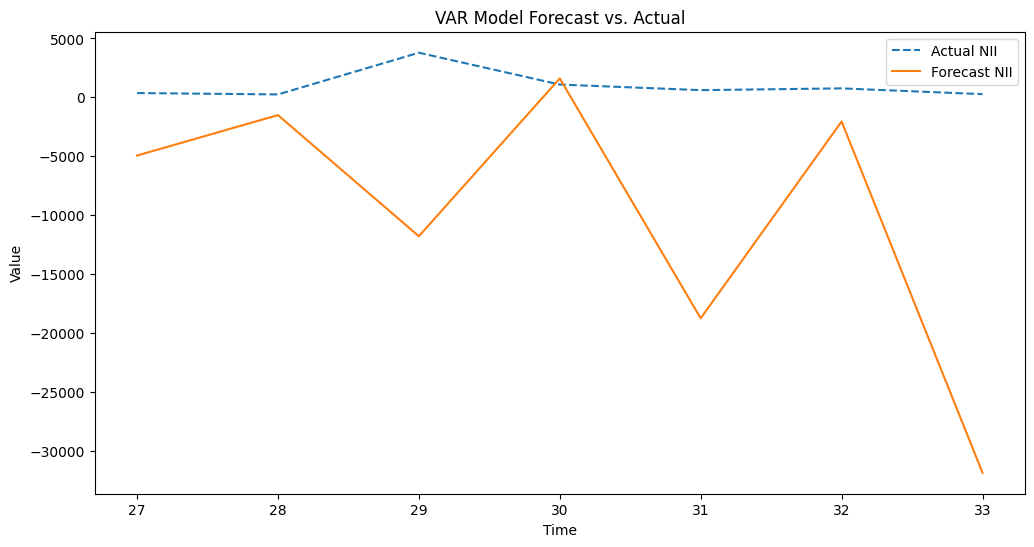

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

# Function to check stationarity using ADF Test
def adf_test(series, alpha=0.05):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1] < alpha  # Returns True if series is stationary

# Load your dataset (already differenced from GC test)
hdfc_diff = hdfc.copy()
hdfc_diff = hdfc_diff.drop(['QUARTERS'], axis=1)
hdfc_diff['NII'] = hdfc['NII'].diff(1)
hdfc_diff['GROSS ADVANCE'] = hdfc['GROSS ADVANCE'].diff(1)
hdfc_diff['GNPA'] = hdfc['GNPA'].diff(1)
hdfc_diff['GNPAR'] = hdfc['GNPAR'].diff(1)
hdfc_diff['CASA'] = hdfc['CASA'].diff(1)
hdfc_diff['PCR'] = hdfc['PCR'].diff(1)
hdfc_diff['WDR'] = hdfc['WDR'].diff(1)
hdfc_diff['WLR'] = hdfc['WLR'].diff(1)
hdfc_diff = hdfc_diff.dropna()

# Use only significant predictors from GC test
selected_vars = ["GROSS ADVANCE", "PCR", "GNPAR", "WDR", "WLR", "NII"]

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(hdfc_diff))
train, test = hdfc_diff[selected_vars].iloc[:train_size], hdfc_diff[selected_vars].iloc[train_size:]

# Select best lag order for VAR model
model = VAR(train)
lag_selection = model.select_order(maxlags=2)  
best_lag = lag_selection.aic  # Using AIC criterion
print(f"Optimal Lag Order: {best_lag}")

# Fit the VAR Model
var_model = model.fit(best_lag)
print(var_model.summary())

# Forecast future values
forecast_steps = len(test)  # Forecast same number of steps as test set
forecast_input = train.values[-best_lag:]  # Last `best_lag` observations
forecast = var_model.forecast(forecast_input, steps=forecast_steps)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=selected_vars)

# Calculate MAPE for each variable
mape_values = {}
for col in selected_vars:
    mape_values[col] = mean_absolute_percentage_error(test[col], forecast_df[col])
    
# Display MAPE values
print("\nMean Absolute Percentage Error (MAPE) for each variable:")
for key, value in mape_values.items():
    print(f"{key}: {value:.2f}")

# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
for col in ['NII']:
    plt.plot(test.index, test[col], label=f"Actual {col}", linestyle='dashed')
    plt.plot(test.index, forecast_df[col], label=f"Forecast {col}")
plt.legend()
plt.title("VAR Model Forecast vs. Actual")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


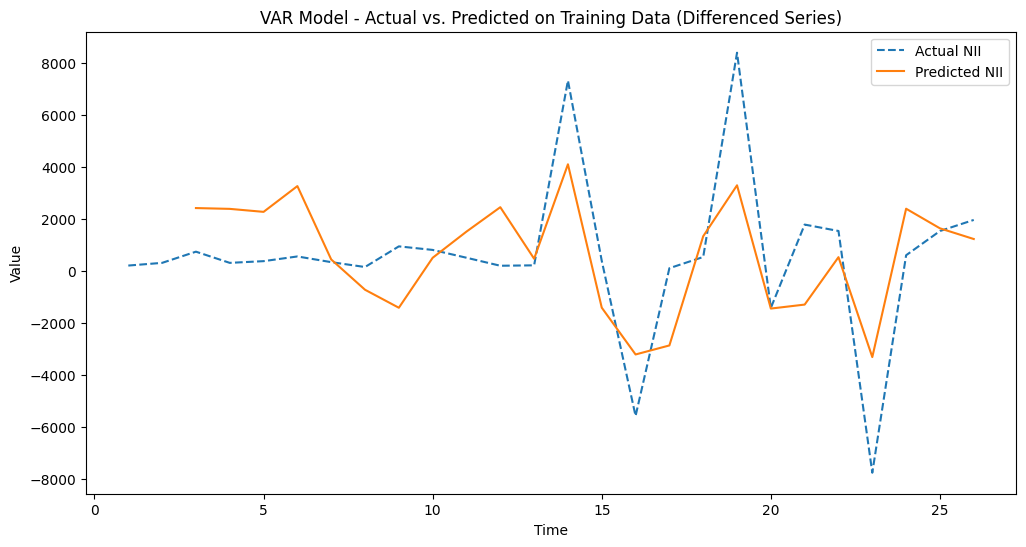

In [13]:
# Plot actual vs. predicted values for train data
train_pred = var_model.fittedvalues  

plt.figure(figsize=(12, 6))
for col in ["NII"]:
    plt.plot(train.index, train[col], label=f"Actual {col}", linestyle='dashed')
    plt.plot(range(3,27), train_pred[col], label=f"Predicted {col}")
plt.legend()
plt.title("VAR Model - Actual vs. Predicted on Training Data (Differenced Series)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

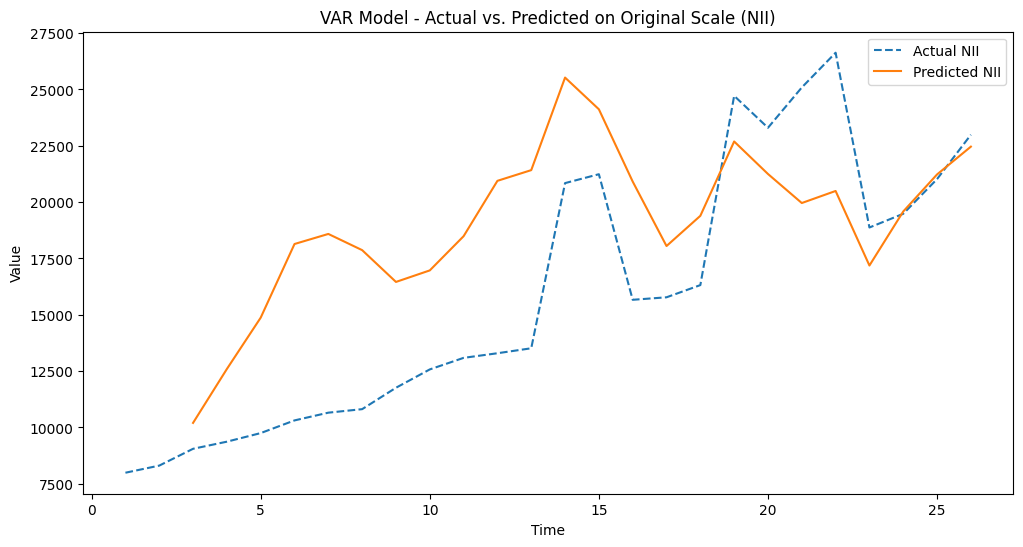

In [14]:
# Reverse differencing to reconstruct original values
train_pred_original = train_pred.copy()
train_pred_original["NII"] = hdfc["NII"].iloc[train.index[0] - 1] + train_pred["NII"].cumsum()

# Plot actual vs. predicted values in original scale
plt.figure(figsize=(12, 6))
plt.plot(hdfc.loc[train.index, "NII"], label="Actual NII", linestyle='dashed')
plt.plot(train_pred_original["NII"], label="Predicted NII")
plt.legend()
plt.title("VAR Model - Actual vs. Predicted on Original Scale (NII)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


## VARIMA

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

# Function to check stationarity using ADF Test
def adf_test(series, alpha=0.05):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1] < alpha  # Returns True if series is stationary

# Load your dataset (already differenced from GC test)
hdfc_diff = hdfc.copy()
hdfc_diff = hdfc_diff.drop(['QUARTERS'], axis=1)
hdfc_diff['NII'] = hdfc['NII'].diff(1)
hdfc_diff['GROSS ADVANCE'] = hdfc['GROSS ADVANCE'].diff(1)
hdfc_diff['GNPA'] = hdfc['GNPA'].diff(1)
hdfc_diff['GNPAR'] = hdfc['GNPAR'].diff(1)
hdfc_diff['CASA'] = hdfc['CASA'].diff(1)
hdfc_diff['PCR'] = hdfc['PCR'].diff(1)
hdfc_diff['WDR'] = hdfc['WDR'].diff(1)
hdfc_diff['WLR'] = hdfc['WLR'].diff(1)
hdfc_diff = hdfc_diff.dropna()

# Use only significant predictors from GC test
selected_vars = ["GROSS ADVANCE", "GNPA", "GNPAR", "CASA", "WDR", "WLR", "NII"]

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(hdfc_diff))
train, test = hdfc_diff[selected_vars].iloc[:train_size], hdfc_diff[selected_vars].iloc[train_size:]

# Fit the VARIMA Model (VAR(2), I(1), MA(0))
varima_model = VARMAX(train, order=(2,0,1))  # VARIMA(p=2, d=1, q=0)
varima_result = varima_model.fit(disp=False,missing='none')
# print(varima_result.summary())

# Forecast future values
forecast_steps = len(test)  # Forecast same number of steps as test set
forecast = varima_result.forecast(steps=forecast_steps)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=selected_vars)

# Calculate MAPE for each variable
mape_values = {}
for col in selected_vars:
    mape_values[col] = mean_absolute_percentage_error(test[col], forecast_df[col])
    
# Display MAPE values
print("\nMean Absolute Percentage Error (MAPE) for each variable:")
for key, value in mape_values.items():
    print(f"{key}: {value:.2f}")

ValueError: Input contains NaN.

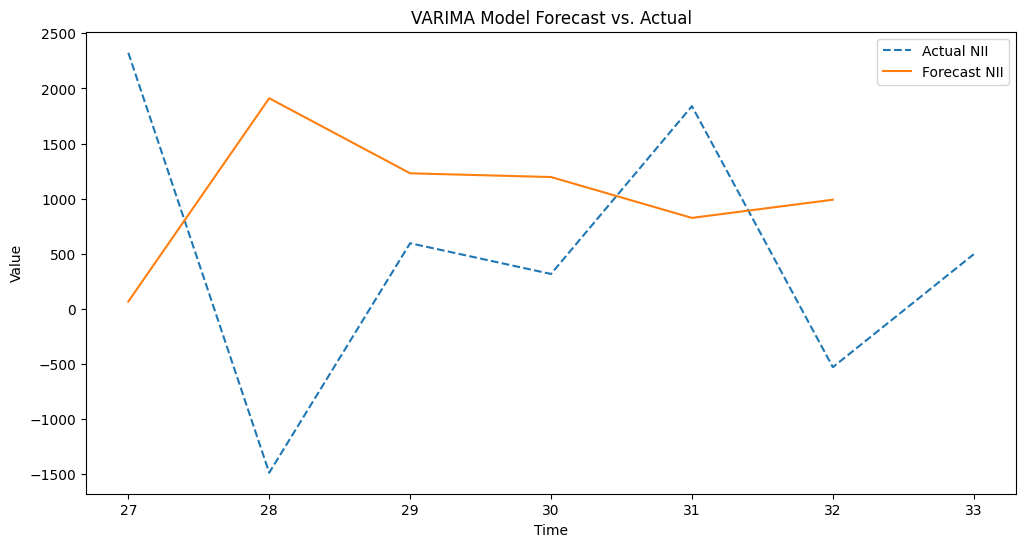

In [91]:
# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
for col in ['NII']:
    plt.plot(test.index, test[col], label=f"Actual {col}", linestyle='dashed')
    plt.plot(test.index, forecast_df[col], label=f"Forecast {col}")
plt.legend()
plt.title("VARIMA Model Forecast vs. Actual")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

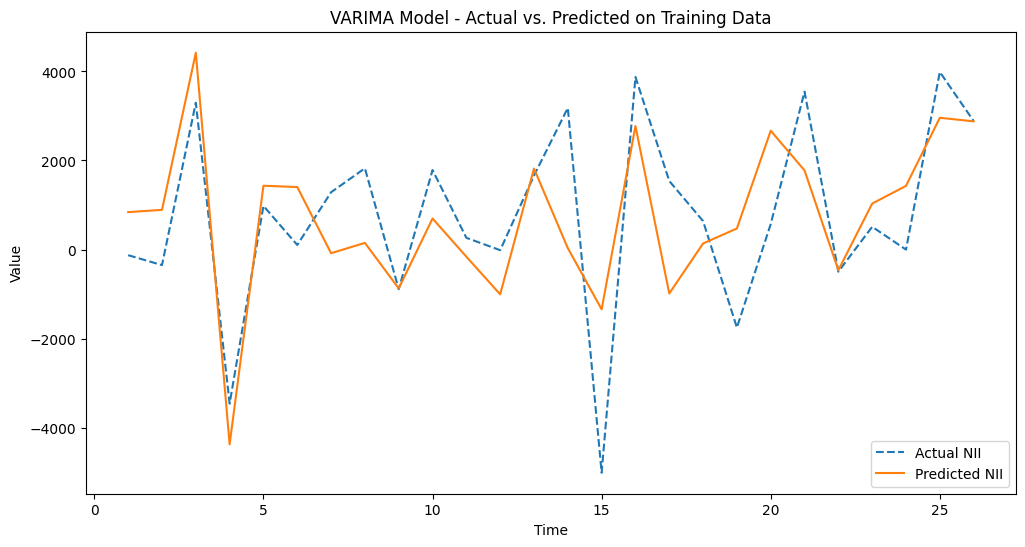

In [92]:
# Plot actual vs. predicted values for train data
train_pred = varima_result.fittedvalues  

plt.figure(figsize=(12, 6))
for col in ['NII']:
    plt.plot(train.index, train[col], label=f"Actual {col}", linestyle='dashed')
    plt.plot(train.index, train_pred[col], label=f"Predicted {col}")
plt.legend()
plt.title("VARIMA Model - Actual vs. Predicted on Training Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


In [93]:
pd.DataFrame([varima_result.fittedvalues['NII'],var_model.fittedvalues['NII']])

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
NII,839.648236,890.759849,4419.434450,-4374.818306,1432.375470,1403.159471,-82.577809,149.357547,-874.417350,697.321716,...,-987.173540,135.843502,473.190002,2668.372603,1776.240734,-464.055413,1031.648687,1429.225826,2958.684149,2878.593447
NII,NaN,NaN,3549.807569,-3355.382248,972.904632,1819.272238,-365.181670,951.977044,78.915989,761.402663,...,-233.750561,-141.325537,-1885.057238,2525.528492,3057.305618,337.278426,1712.027998,1257.968265,3116.568045,1509.653055


- varima = did not fit well as compared to var

- var =  order 2

- Your tasks: 
1. Carry out same procedure carefully for hdfc.

In [10]:
# import itertools
# from statsmodels.tsa.stattools import grangercausalitytests
# import warnings
# warnings.filterwarnings("ignore")

# maxlag = 10
# test = "params_ftest"

# # create all pair variable names (Y, X)
# pairs = itertools.product(hdfc.columns[1:], hdfc.columns[1:])
# causation_dict = {}
# for pair in pairs:
#   y, x = pair[0], pair[1]

#   # run causality test
#   test_result = grangercausalitytests(hdfc[[y, x]], maxlag=maxlag, verbose=False)
#   print(test_result)
#   pvalues = [x[0][test][1] for x in list(test_result.values())]
#   print(pvalues)
#   min_p = min(pvalues)

#   # store in dictionary
#   y_str, x_str = "{}_y".format(y), "{}_x".format(x)
#   if y_str not in causation_dict:
#     causation_dict[y_str] = {}
#   causation_dict[y_str][x_str] = min_p

# # convert to dataframe
# causation_matrix = pd.DataFrame(causation_dict).round(4).T
# causation_matrix

In [63]:
import itertools

maxlag = 8
test = "params_ftest"

# create all pair variable names (Y, X)
pairs = itertools.product(hdfc_diff.columns[:], hdfc_diff.columns[:])
causation_dict = {}
for pair in pairs:
  y, x = pair[0], pair[1]

  # run causality test
  test_result = grangercausalitytests(hdfc_diff[[y, x]], maxlag=maxlag, verbose=False)
  print(test_result)
  pvalues = [x[0][test][1] for x in list(test_result.values())]
  print(pvalues)
  min_p = min(pvalues)

  # store in dictionary
  y_str, x_str = "{}_y".format(y), "{}_x".format(x)
  if y_str not in causation_dict:
    causation_dict[y_str] = {}
  causation_dict[y_str][x_str] = min_p

# convert to dataframe
causation_matrix = pd.DataFrame(causation_dict).round(4).T
causation_matrix

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

{1: ({'ssr_ftest': (-4.389842320765455e-15, 1.0, 25.0, 1), 'ssr_chi2test': (-4.7410297064266925e-15, 1.0, 1), 'lrtest': (-0.0, 1.0, 1), 'params_ftest': (39.95765742673086, 1.2910371161668153e-06, 25.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712AEDE10>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712AD0BD0>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (4.476944675367763e-15, 0.9999999999999949, 23.0, 2), 'ssr_chi2test': (1.0121787961701027e-14, 0.9999999999999949, 2), 'lrtest': (-0.0, 1.0, 2), 'params_ftest': (76.82491783668506, 6.577606366768794e-11, 23.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128B71D0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128B53D0>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest': (3.103818775654866e-15, 0.9999999999999999, 21.0, 3), 'ssr_chi2test': (1.1085

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

{1: ({'ssr_ftest': (1.57069905377951, 0.222178198109675, 24.0, 1), 'ssr_chi2test': (1.7670364355019488, 0.18374926912800085, 1), 'lrtest': (1.711619029999838, 0.19077544431861126, 1), 'params_ftest': (1.5706990537795102, 0.222178198109675, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128B0250>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712ACEED0>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (0.23064366592630678, 0.7960072425966056, 21.0, 2), 'ssr_chi2test': (0.5711176489603786, 0.7515941277440583, 2), 'lrtest': (0.564935414803017, 0.7539209876339743, 2), 'params_ftest': (0.23064366592630403, 0.7960072425966076, 21.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712AF47D0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712902590>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest': (0.510764555

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

{1: ({'ssr_ftest': (0.34827594449372035, 0.560606775996207, 24.0, 1), 'ssr_chi2test': (0.3918104375554354, 0.5313492909021362, 1), 'lrtest': (0.38899476647429765, 0.5328282688960517, 1), 'params_ftest': (0.3482759444937258, 0.5606067759962055, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128B4750>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128B6010>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (0.44418597204345084, 0.6472339132645513, 21.0, 2), 'ssr_chi2test': (1.099889073631402, 0.5769818107415638, 2), 'lrtest': (1.0772605124284382, 0.5835470150966049, 2), 'params_ftest': (0.44418597204344146, 0.6472339132645568, 21.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712938910>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128F91D0>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest': (0.64449

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

{1: ({'ssr_ftest': (0.0068714270339633055, 0.934623279101865, 24.0, 1), 'ssr_chi2test': (0.0077303554132087185, 0.929938321320578, 1), 'lrtest': (0.007729248987445203, 0.9299433224679272, 1), 'params_ftest': (0.006871427033960268, 0.9346232791018904, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A71293FD50>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7127E7790>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (3.665822294161506, 0.043097179779975056, 21.0, 2), 'ssr_chi2test': (9.077274252209445, 0.010687962977720554, 2), 'lrtest': (7.7858800644923605, 0.020385324337403893, 2), 'params_ftest': (3.665822294161504, 0.043097179779975056, 21.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128B7890>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A71285D690>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (0.6855551297511178, 0.41583828214420615, 24.0, 1), 'ssr_chi2test': (0.7712495209700074, 0.37983078038905094, 1), 'lrtest': (0.7604396007049274, 0.383190985747629, 1), 'params_ftest': (0.6855551297265591, 0.41583828215244134, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A71293C990>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7128B6A50>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (0.586383098711167, 0.5651892335305502, 21.0, 2), 'ssr_chi2test': (1.4519962444276517, 0.48384139501782, 2), 'lrtest': (1.4129011057158891, 0.49339236322817837, 2), 'params_ftest': (0.5863830987107019, 0.5651892335307992, 21.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A71285FAD0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A71285E510>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest': (0.0833833

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

{1: ({'ssr_ftest': (0.00683684584187507, 0.9347876031993658, 24.0, 1), 'ssr_chi2test': (0.007691451572109454, 0.9301143874676672, 1), 'lrtest': (0.007690356253675645, 0.9301193510097865, 1), 'params_ftest': (0.0068368458418725745, 0.9347876031993785, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712954150>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712AF4AD0>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (0.45252687259837865, 0.6420771317941618, 21.0, 2), 'ssr_chi2test': (1.120542732148366, 0.5710540781175063, 2), 'lrtest': (1.0970683645435315, 0.57779613376722, 2), 'params_ftest': (0.45252687260297236, 0.6420771317913347, 21.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712937110>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712937150>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest': (1.

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

{1: ({'ssr_ftest': (0.04042188578345546, 0.8423521402728571, 24.0, 1), 'ssr_chi2test': (0.04547462150638739, 0.8311336915212753, 1), 'lrtest': (0.04543636924373118, 0.8312036601676321, 1), 'params_ftest': (0.04042188578345621, 0.8423521402728571, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A71293B590>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7129372D0>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (0.23744447937353066, 0.7907293561389452, 21.0, 2), 'ssr_chi2test': (0.5879577584487427, 0.7452922324270761, 2), 'lrtest': (0.5814083447021687, 0.747736846535915, 2), 'params_ftest': (0.23744447874902277, 0.7907293566218426, 21.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7127E7590>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7127E4D10>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest': (0.94

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

{1: ({'ssr_ftest': (0.2428800358393987, 0.6266125603078492, 24.0, 1), 'ssr_chi2test': (0.27324004031932353, 0.6011665605066925, 1), 'lrtest': (0.271866703188536, 0.6020823120337097, 1), 'params_ftest': (0.24288003602937033, 0.6266125601736596, 24.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712937310>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A712937090>, array([[0., 1., 0.]])]), 2: ({'ssr_ftest': (0.0592304794448098, 0.9426463949222562, 21.0, 2), 'ssr_chi2test': (0.1466659491014338, 0.929291348134725, 2), 'lrtest': (0.1462538270622531, 0.9294828585881602, 2), 'params_ftest': (0.05923047888521293, 0.9426463954467994, 21.0, 2.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7127B9F50>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001A7127B8290>, array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])]), 3: ({'ssr_ftest': (1.280710

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  

,NII_x,GROSS ADVANCE_x,GNPA_x,GNPAR_x,CASA_x,PCR_x,WDR_x,WLR_x
NII_y,0.0000,0.0641,0.0438,0.0224,0.2728,0.0151,0.0075,0.0098
GROSS ADVANCE_y,0.0059,0.0000,0.0054,0.0097,0.0705,0.0011,0.0166,0.0085
GNPA_y,0.0013,0.0167,0.0000,0.1127,0.0674,0.0103,0.0471,0.0340
GNPAR_y,0.0031,0.1916,0.3508,0.0000,0.0307,0.0002,0.0036,0.0253
CASA_y,0.0002,0.1147,0.0017,0.0100,0.0000,0.0394,0.2486,0.0006
PCR_y,0.0003,0.3543,0.1881,0.1581,0.0832,0.0000,0.0103,0.0188
WDR_y,0.0037,0.3314,0.0300,0.0052,0.0450,0.0021,0.0000,0.0174
WLR_y,0.0959,0.0052,0.1644,0.1359,0.0516,0.1633,0.1448,0.0000


In [28]:
from statsmodels.tsa.stattools import adfuller
for c in hdfc.columns[1:]:
    # Perform ADF test
    result = adfuller(hdfc[c])
    print(c)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    
    
    # Check p-value
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")


NII
ADF Statistic: 1.0338176428618615
p-value: 0.9946102534300967
The series is not stationary.
GROSS ADVANCE
ADF Statistic: 3.131965861266027
p-value: 1.0
The series is not stationary.
GNPA
ADF Statistic: -1.4926635302467062
p-value: 0.53713741339593
The series is not stationary.
GNPAR
ADF Statistic: -1.4087430896875335
p-value: 0.5780774680905377
The series is not stationary.
CASA
ADF Statistic: -1.3872299538543449
p-value: 0.5883826969029664
The series is not stationary.
PCR
ADF Statistic: -2.8499125650320574
p-value: 0.051490213638371314
The series is not stationary.
WDR
ADF Statistic: -2.6398143419607267
p-value: 0.08504443329389483
The series is not stationary.
WLR
ADF Statistic: -2.1458181407914276
p-value: 0.22649423084063447
The series is not stationary.


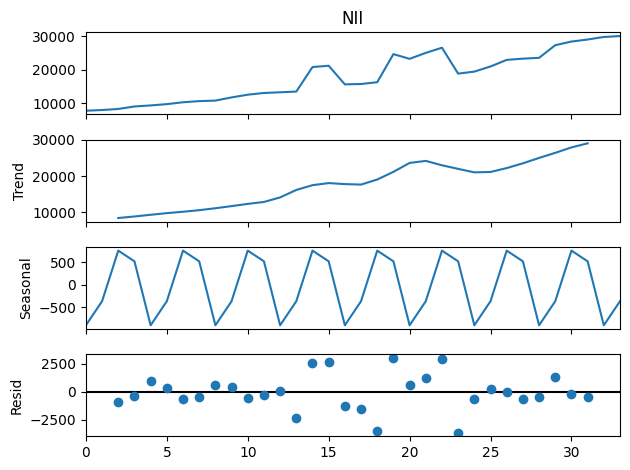

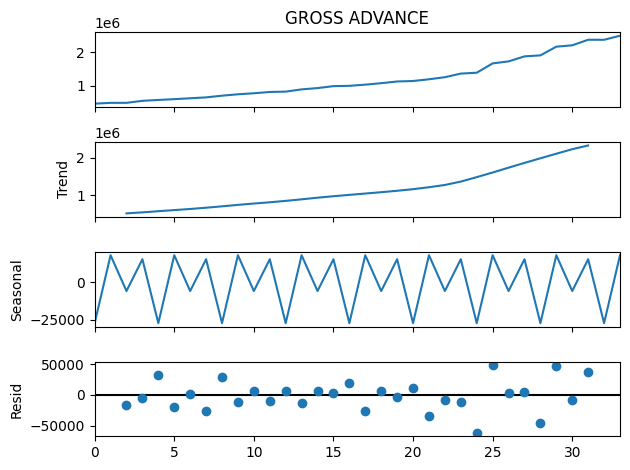

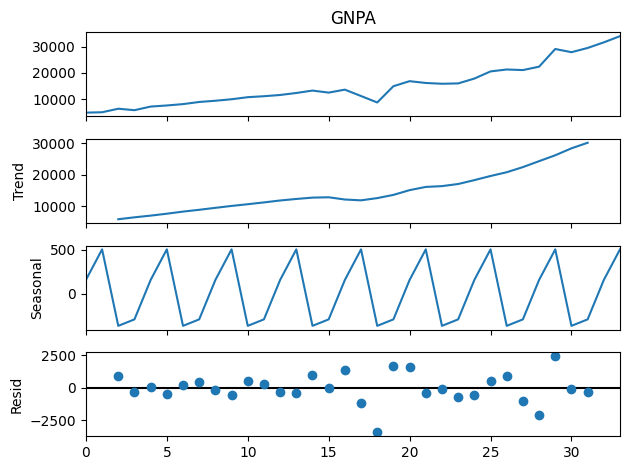

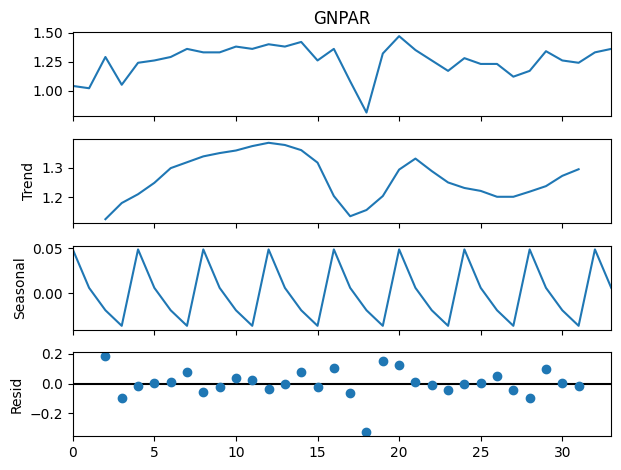

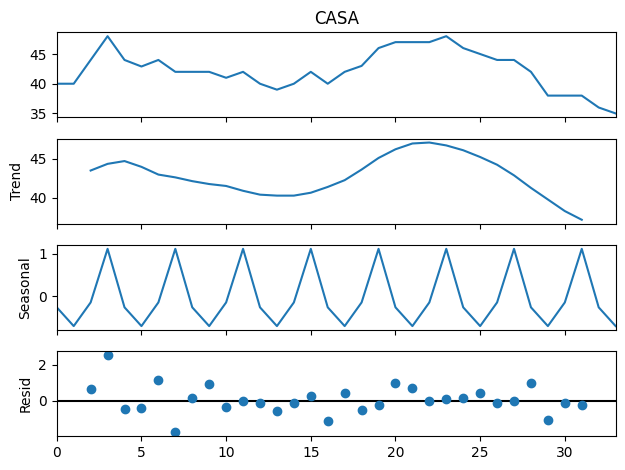

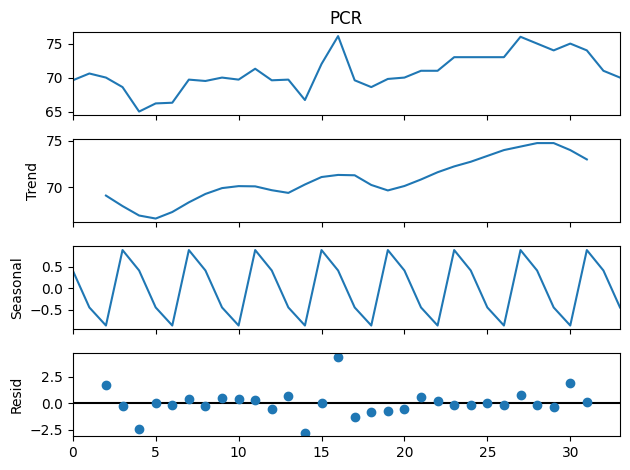

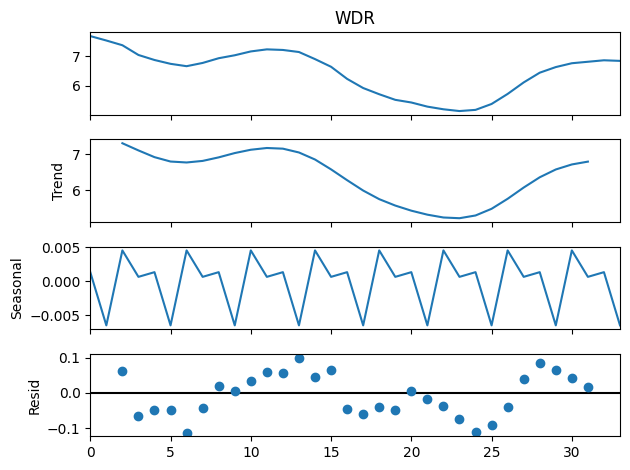

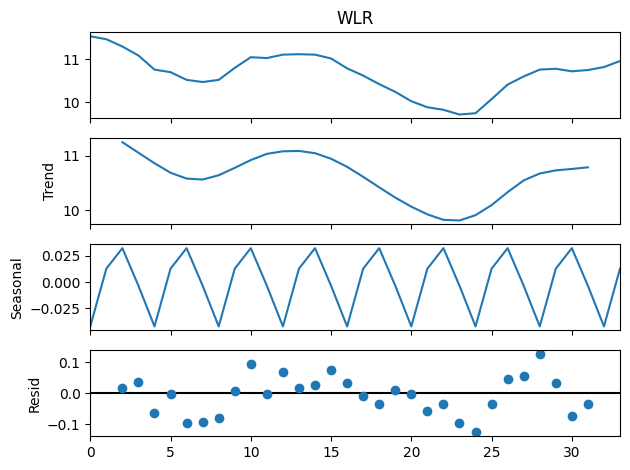

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
resid_hdfc=pd.DataFrame()
for c in hdfc.columns[1:]:
    decomposition = seasonal_decompose(hdfc[c], model='additive', period=4)
    # Plot decomposition results
    decomposition.plot()
    plt.show()

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    resid_hdfc[c]=residual[2:-2]


In [42]:
resid_hdfc

,NII,GROSS ADVANCE,GNPA,GNPAR,CASA,PCR,WDR,WLR
2,-1372.704241,-10062.945312,-36933.206836,-1.927232,2.550251,1.714916,0.044124,0.052204
3,2325.358259,-4736.789062,12234.321133,0.564330,-0.233343,-10.430240,-0.011032,0.051110
4,-598.898438,-3412.722098,9173.033209,0.546540,-0.353811,1.544180,-0.010028,-0.027818
5,-466.880580,-1469.043527,-8116.022506,-0.317388,0.101903,4.326144,-0.023064,-0.001747
6,-971.454241,-19321.570312,3928.793164,0.326518,-0.115999,-0.830084,-0.130876,-0.049046
7,-119.016741,5156.835938,11712.571133,0.408080,0.362907,1.809760,-0.046032,-0.031390
8,1622.601562,-28706.472098,1475.408209,0.237790,-0.088811,3.545430,0.032472,0.024682
9,-1011.755580,4947.081473,3992.841244,0.200112,0.029403,-12.485106,-0.015564,0.012003
10,39.170759,4313.179688,5582.578164,0.216518,-0.243499,3.031166,0.021624,0.020954
11,78.233259,24757.960938,-9359.083867,-0.596920,0.344157,4.513510,0.017718,-0.078890


In [55]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

test_result = coint_johansen(hdfc.drop("QUARTERS",axis=1), det_order=-1, k_ar_diff=5)
# test result and significance level
test_stats, sign_levels = test_result.lr1, test_result.cvt

ranks = range(hdfc.columns.shape[0]-1)
for rank, test_stat, sign_level in zip(ranks, test_stats, sign_levels):
  print("Rank <= {} is {}. Test stat: {}. Significance Level: [90%] {}, [95%] {}, [99%] {}".format(rank, test_stat >= sign_level[1], round(test_stat, 4), *sign_level))

Rank <= 0 is True. Test stat: 1431.1012. Significance Level: [90%] 137.9954, [95%] 143.6691, [99%] 154.7977
Rank <= 1 is True. Test stat: 1045.1848. Significance Level: [90%] 106.7351, [95%] 111.7797, [99%] 121.7375
Rank <= 2 is True. Test stat: 763.692. Significance Level: [90%] 79.5329, [95%] 83.9383, [99%] 92.7136
Rank <= 3 is True. Test stat: 487.134. Significance Level: [90%] 56.2839, [95%] 60.0627, [99%] 67.6367
Rank <= 4 is True. Test stat: 290.5292. Significance Level: [90%] 37.0339, [95%] 40.1749, [99%] 46.5716
Rank <= 5 is True. Test stat: 151.5. Significance Level: [90%] 21.7781, [95%] 24.2761, [99%] 29.5147
Rank <= 6 is True. Test stat: 39.0198. Significance Level: [90%] 10.4741, [95%] 12.3212, [99%] 16.364
Rank <= 7 is True. Test stat: 13.9379. Significance Level: [90%] 2.9762, [95%] 4.1296, [99%] 6.9406


NII True
GROSS ADVANCE False
GNPA True
GNPAR True
CASA True
PCR True
WDR False
WLR False
1
NII True
GROSS ADVANCE False
GNPA True
GNPAR True
CASA True
PCR True
WDR False
WLR True
2
NII True
GROSS ADVANCE False
GNPA True
GNPAR True
CASA True
PCR True
WDR True
WLR True
3
NII True
GROSS ADVANCE True
GNPA True
GNPAR True
CASA True
PCR True
WDR False
WLR True
4
NII True
GROSS ADVANCE True
GNPA True
GNPAR True
CASA True
PCR True
WDR False
WLR True
5
NII True
GROSS ADVANCE True
GNPA True
GNPAR True
CASA True
PCR True
WDR True
WLR True
6
number of times differencing 6


[]

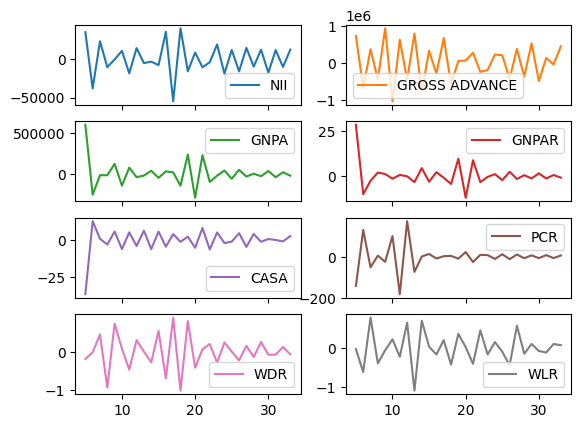

In [62]:
is_stationary = False
hdfc_diff = hdfc.drop("QUARTERS",axis=1).copy()
count_diff = 0

while not is_stationary:
  hdfc_diff = hdfc_diff.diff().dropna()
  is_stationary = adftest(hdfc_diff)
  count_diff += 1
  print(count_diff)
  
print("number of times differencing", count_diff)
hdfc_diff.plot(subplots=True, layout=(4, 2))
plt.plot()

In [59]:
def adftest(df):
  is_stationary = True
  for col in df.columns.values:
    test_result = adfuller(df[col], autolag="AIC")
    if test_result[1] > 0.05:
      is_stationary = False
    print(col, test_result[1] < 0.05)

  return is_stationary


In [74]:
model = VAR(hdfc_diff)
model.select_order(maxlags=2).summary()

C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,72.59,72.98,3.361e+31,72.71
1,61.81,65.27,8.635e+26,62.84
2,41.66*,48.19*,7.365e+18*,43.61*


In [72]:
hdfc_diff.shape

(29, 8)

In [75]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 31, Dec, 2024
Time:                     01:53:07
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    48.1917
Nobs:                     27.0000    HQIC:                   43.6054
Log likelihood:          -732.962    FPE:                7.36522e+18
AIC:                      41.6645    Det(Omega_mle):     1.48073e+17
--------------------------------------------------------------------
Results for equation NII
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                  -56.922946       598.287472           -0.095           0.924
L1.NII                  -1.242811         0.131485           -9.452           0.000
L1.GROSS ADVANCE        -0.023430         0.007556

In [77]:
from statsmodels.stats.stattools import durbin_watson

test_result = durbin_watson(model_fitted.resid)

list(zip(hdfc_diff.columns, test_result))
# results are close to two so no serial correlation left

[('NII', 1.802393759735701),
 ('GROSS ADVANCE', 1.9319066625447396),
 ('GNPA', 1.437502223754217),
 ('GNPAR', 1.7710741095005653),
 ('CASA', 2.0464662062035783),
 ('PCR', 0.9748661584449254),
 ('WDR', 2.0556066516676794),
 ('WLR', 1.5372365706118347)]